# Who feeds the world ? And how wealthy are they ?

## Abstract <a name="abstract"></a>

Our main goal in this project is to find social and economic world-wide relations of countries based on the state of their agricultural sector, using indicators such as imports, exports, production, self-sufficiency, etc. In order to find such indicators, we would like to use the data from the "Global Food & Agriculture Statistics" datasets. First, we would like to produce a map showing which countries "feed the world" i.e. which countries are net-exporting food. That map would contain a slider to show how this evolved over the past fifty years. Then we would like to show countrywise the level of food self-sufficiency i.e. the way a country does not need to trade with other ones in order to feed its population. We will also compare it to nations' economic development and see if some correlations can be found. We will visualize our best findings with several interactive maps and plots.

## Research questions <a name="abstract2"></a>

We would like to work on the following research questions:

- How does the production and consumption of food look like from a geographical point of view ? Which countries are net food exporters or importers? How did this evolve over the last few decades ?
- What's the level of self-sufficiency in food production of individual countries and how does this change over time ?
- Is there a link between the GDP per capita and the agricultural trade balance ? Are countries that are net exporters or importers richer ? Are self-sufficient countries richer ?
- If we find any relations, are they also still valid if we check for specific crops ? Are there some crops that are mostly produced by richer countries, some that are mostly produced by poorer countries?


# Table of contents <a name="toc"></a>


[Abstract](#abstract)

[Research questions](#abstract2) 

[Table of contents](#toc)

1. [Data cleansing and preprocessing](#1)

    1. [Dataset description](#1A)   
    
    2. [Loading the data set](#1B)
    
    3. [Understanding the data set](#1C)
    
    4. [Cleansing the data set](#1D)
        
    5. [Preprocessing the data set](#1E)
        
    6. [Making one uniformized dataframe](#1F)
        
2. [Data exploration and first observations](#2)
        
    1. [Food productions, importations and exportations](#2A)
            
    2. [Prices of food](#2B)  
                
    3. [Structure of international trade](#2C)      
        
    4. [Economic classification of countries](#2D)    
        
3. [Descriptive data analysis](#3)

    1. [Production and consumption of food from a time-space geography point of view](#3A)

    1. [Food self-sufficiency](#3B)

    2. [Giving countries an economic score based on their agricultural features](#3C)

    3. [Food prices stability and agricultural features](#3C)      

4. [Informed plan for next actions](#4)

**External imports:**

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import json
import re
import requests
from bs4 import BeautifulSoup
from ipywidgets import interact
from IPython.display import display

**Auxiliary function imports:**

We have implemented some functions into a dedicated module (file `Milestone_2_scripts.py`) in order to simplify the code and make this notebook more enjoyable to read.

In [2]:
from Milestone_2_scripts import *

**Setup:**

In [3]:
data_folder_path = "./Data/current_FAO/raw_files/"

files = {"Crops production" : "Production_Crops_E_All_Data_(Normalized).csv",
         "Crops trade" : "Trade_Crops_Livestock_E_All_Data_(Normalized).csv", 
         "Population" : "Population_E_All_Data_(Norm).csv",
         "Macroeconomy" : "Macro-Statistics_Key_Indicators_E_All_Data_(Normalized).csv",
         "Livestock production" : "Production_Livestock_E_All_Data_(Normalized).csv",
         "Live animals trade" : "Trade_LiveAnimals_E_All_Data_(Normalized).csv"
        }
interesting_datasets = files.keys()

## 1. Data cleansing and preprocessing <a name="1"></a>

In this part, we will load, explore and clean the dataset in order to remove typing errors, missing information, inaccuracies, and so on.

1. 

    1. [Dataset description](#1A)   
    
    2. [Loading the data set](#1B)
    
    3. [Understanding the data set](#1C)
    
    4. [Cleansing the data set](#1D)
    
        1. [Removing unusefull data](#1Da)         
    
            1. [Extracting GDP from the macroeconomy dataset](#1Dai)
        
        2. [Handling of the missing data](#1Db)
        
            1. [Highlighting the problem](#1Dbi)
            
            2. [Proposed correction](#1Dbii)
        
        3. [Correcting inconsistent data entries](#1Dc)
        
    5. [Preprocessing the data set](#1E)
    
        1. [Converting country names between different naming conventions](#1Ea)
        
        2. [Normalization and log scales](#1Eb)
        
    6. [Making one uniformized dataframe](#1F)

### 1.A. Dataset description <a name="1A"></a>

Our main dataset would be a subset of the "Global Food & Agriculture Statistics" that is found in the proposed datasets list. In this dataset, we have seen that we could work with the production as well as import and export quantities per year and per country. We will add information about countries GDP to this database.

### 1.B. Loading the data set  <a name="1B"></a>

In [4]:
def load_datasets(datasets) :
    df = {}
    for dataset in datasets :
        file_path = data_folder_path + files[dataset]
        df[dataset] = pd.read_csv(file_path, encoding = "ISO-8859-1")
    return df

We load each interresting dataset in the dictionary `df` :

In [5]:
df = load_datasets(interesting_datasets)

### 1.C. Understanding the data set  <a name="1C"></a>

In this part, we will have a first look of the datasets in order to get a first sense of the data.

In [6]:
def display_df(df, datasets):
    for dataset in datasets :
        display(dataset, df[dataset].sample(5))

In order to see what does the datasets look like, we display a sample of 5 rows for each of them :

In [7]:
display_df(df, interesting_datasets)

'Crops production'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
2488987,5801,Least Developed Countries,122,Sweet potatoes,5419,Yield,2003,2003,hg/ha,48406.0,Fc
1130209,143,Morocco,101,Canary seed,5510,Production,1982,1982,tonnes,6000.0,NaN
1331293,170,Peru,1800,"Vegetables&Melons, Total",5312,Area harvested,1963,1963,ha,62150.0,A
1900318,5000,World,402,"Onions, shallots, green",5419,Yield,1997,1997,hg/ha,160550.0,Fc
710576,87,Guadeloupe,568,"Melons, other (inc.cantaloupes)",5419,Yield,1988,1988,hg/ha,185600.0,Fc


'Crops trade'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
6855660,144,Mozambique,230,"Cashew nuts, shelled",5622,Import Value,1969,1969,1000 US$,NaN,M
1400607,21,Brazil,780,Jute,5610,Import Quantity,1973,1973,tonnes,15320.0,NaN
5460790,109,Jamaica,1904,Animal fats,5922,Export Value,2012,2012,1000 US$,0.0,A
5521343,110,Japan,687,Pepper (piper spp.),5610,Import Quantity,1986,1986,tonnes,5566.0,NaN
14382970,5803,Small Island Developing States,1890,Sugar and Honey,5622,Import Value,1992,1992,1000 US$,274416.0,A


'Population'

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
181862,5304,South-Eastern Asia,3010,Population - Est. & Proj.,561,Urban population,2078,2078,1000,0.000,XUru
106950,151,Netherlands Antilles (former),3010,Population - Est. & Proj.,551,Rural population,1952,1952,1000,33.000,Fc
2229,3,Albania,3010,Population - Est. & Proj.,561,Urban population,2065,2065,1000,0.000,XUru
37417,47,Cook Islands,3010,Population - Est. & Proj.,551,Rural population,2004,2004,1000,6.000,XUru
131475,192,San Marino,3010,Population - Est. & Proj.,511,Total Population - Both sexes,2065,2065,1000,31.638,XU


'Macroeconomy'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
468733,176,Timor-Leste,22015,Gross Fixed Capital Formation,6109,Value Local Currency,1988,1988,millions,NaN,XAM
396432,188,Saint Kitts and Nevis,22015,Gross Fixed Capital Formation,6155,Annual growth Local Currency,2014,2014,%,15.093570,Fc
193198,85,Greenland,22016,"Value Added (Agriculture, Forestry and Fishing)",6155,Annual growth Local Currency,2013,2013,%,1.913800,Fc
397479,188,Saint Kitts and Nevis,22075,Value Added (Total Manufacturing),6156,"Annual growth Local Currency, 2005 prices",1990,1990,%,-7.421316,Fc
457884,211,Switzerland,22016,"Value Added (Agriculture, Forestry and Fishing)",6103,Share of GDP in US$,1995,1995,%,1.502742,Fc


'Livestock production'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
55721,100,India,1126,Camels,5111,Stocks,1970,1970,Head,1110000.0,F
38381,60,El Salvador,976,Sheep,5111,Stocks,2001,2001,Head,5100.0,F
100124,191,Saint Vincent and the Grenadines,866,Cattle,5111,Stocks,1963,1963,Head,6800.0,NaN
64245,118,Kuwait,1126,Camels,5111,Stocks,2012,2012,Head,9089.0,NaN
23980,351,China,1140,Rabbits and hares,5112,Stocks,1971,1971,1000 Head,33084.0,A


'Live animals trade'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
485885,229,United Kingdom,1884,Live Animals,5922,Export Value,1990,1990,1000 US$,4.458980e+05,A
96292,40,Chile,1922,Sheep and Goats,5922,Export Value,2006,2006,1000 US$,5.400000e+01,A
637021,5706,European Union,1171,Animals live nes,5922,Export Value,2013,2013,1000 US$,9.908000e+03,A
399639,193,Sao Tome and Principe,1882,"Agricult.Products,Total",5622,Import Value,1999,1999,1000 US$,1.009800e+04,A
530063,5000,World,10,Total Merchandise Trade,5622,Import Value,2011,2011,1000 US$,1.839174e+10,A


At first glance, our datasets seem very clean.

Each of our dataset contains a column "Year" and a column that is either named "Area" or "Country". This is a great news for us since we want to do a both geographical and time-related analysis.

The columns "Area" and "Country" both correspond to the country except that the "Area" may contains a group of country (e.g. "Eastern Europe").

### 1.D. Cleansing the data set  <a name="1D"></a>

In this part, we will clean the datasets. The final goal is to produce one uniformized and normalized dataset on which we could work (see [1.F](#1F)).

Such a cleaned dataset may look like this  (in a very simplistic way):

    Country | Year | GDP | Crops production | Livestock production

#### 1.D.a. Removing unusefull data  <a name="1Da"></a>

In this section, we will create dataframes in `df_useful` which correspond to previous dataframes without the unusefull data.

In [8]:
df_useful = {}

##### 1.D.a.i. Extracting GDP from the macroeconomy dataset <a name="1Dai"></a>

In [9]:
def extract_GDP(df):
    def selection_GDP(df):
        return df['Item']=='Gross Domestic Product'
    def selection_US_dollars(df):
        return df['Element']=="Value US$"
    def drop_columns(df):
        dropped_colmuns = ["Item Code", "Item", "Element Code", "Element", "Flag", "Year Code", "Unit"]
        return df.drop(columns = dropped_colmuns)
    return drop_columns(df[selection_GDP(df)&selection_US_dollars(df)])

In [10]:
df_useful["GDP"] = extract_GDP(df["Macroeconomy"])

In [11]:
display(df_useful["GDP"].sample(5))

,Area Code,Area,Year,Value
436301,202,South Africa,1996,149744.158270
151453,59,Egypt,1982,15747.627222
520993,246,Yemen Ar Rp,1986,2441.891988
116472,48,Costa Rica,1981,3125.359526
490260,226,Uganda,1981,3687.893276


##### 1.D.a.ii. ... <a name="1Daii"></a>

TODO crops and livestock, production and trade

In [12]:
def get_food_crops():

#Return a list of crops categorized as food crops https://world-crops.com/food-crops/

    url="https://world-crops.com/food-crops/"
    r=requests.get(url,headers={"User-Agent": "XY"})
    soup=BeautifulSoup(r.text,'html.parser')
    elements_temp=soup.find_all('a',href=re.compile("^../"))
    elements=[el.text for el in elements_temp]
    
    #only 40 elements are displayed on each page->iterating on the total list
    for i in range(40,401,40):
        url_i=url+"?ss="+str(i)
        r=requests.get(url_i,headers={"User-Agent":"XY"})
        soup=BeautifulSoup(r.text,'html.parser')
        new_elements=soup.find_all('a',href=re.compile("^../"))
        elements+=[el.text for el in new_elements]
    return elements


def inclusive_search(string,elements):

#returns true if the string can be found in elements. The search removes special characters from string in order to include more positive results

    string=string.lower()
    delimiters = ",", "(","&",")"," and "," "
    pattern = '|'.join(map(re.escape, delimiters))
    strings=list(filter(None,re.split(pattern,string)))
    found=False
    for s in strings:
        if s=="nes":
            continue
        for el in elements:
            found=(s in el.split())
            if found==False and s[-1]=="s":
                found=s[:-1] in el.split()
            if found==False and s[-2:]=="es":
                found=s[:-2] in el.split()
            if found==False and s[-3:]=="ies":
                found=s[:-3]+"y" in el.split()
            if found==True:
                return found
    return found


def get_food_crop_data(df):
    
    #extract the food crop data, returns 4 df: Area,Production,Seed and yield
    
    df=df.copy()

    food_crops=list(map(lambda x: x.lower(),get_food_crops()))
              
    crop_types_df=df[['Item','Value']].groupby('Item').sum()
    crop_types_df=crop_types_df[list(map(lambda x : inclusive_search(x,food_crops) , crop_types_df.index ))]
                    
    food_crop_df=df[df.Item.apply(lambda x: x in crop_types_df.index)]

                    
    return (food_crop_df[food_crop_df.Element=='Area harvested'],
            food_crop_df[food_crop_df.Element=='Production'],
            food_crop_df[food_crop_df.Element=='Seed'],
            food_crop_df[food_crop_df.Element=='Yield'])

# NEED TO USE df_cleansed INSTEAD OF df_usefull    
food_crop_area_df , food_crop_production_df , food_crop_seed_df , food_crop_yield_df = get_food_crop_data(df["Crops production"])

In [13]:
display(food_crop_area_df.sample(5))
display(food_crop_production_df.sample(5))
display(food_crop_seed_df.sample(5))
display(food_crop_yield_df.sample(5))

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
1364520,174,Portugal,56,Maize,5312,Area harvested,1984,1984,ha,253791.0,NaN
1710758,223,Turkey,234,"Nuts, nes",5312,Area harvested,1984,1984,ha,NaN,M
2244880,5304,South-Eastern Asia,79,Millet,5312,Area harvested,1976,1976,ha,150140.0,A
622120,68,France,592,Kiwi fruit,5312,Area harvested,1978,1978,ha,119.0,NaN
734618,90,Guinea,254,"Oil, palm fruit",5312,Area harvested,2007,2007,ha,310000.0,F


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
1873029,181,Zimbabwe,780,Jute,5510,Production,1970,1970,tonnes,1000.0,F
443759,98,Croatia,89,Buckwheat,5510,Production,2007,2007,tonnes,350.0,*
1783667,231,United States of America,122,Sweet potatoes,5510,Production,1998,1998,tonnes,561640.0,NaN
2348194,5403,Southern Europe,449,Mushrooms and truffles,5510,Production,1972,1972,tonnes,39313.0,A
915727,110,Japan,15,Wheat,5510,Production,1985,1985,tonnes,874200.0,NaN


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
1807655,235,Uzbekistan,44,Barley,5525,Seed,2012,2012,tonnes,13577.0,Fc
919836,112,Jordan,181,"Broad beans, horse beans, dry",5525,Seed,1981,1981,tonnes,12.0,Fc
394455,44,Colombia,116,Potatoes,5525,Seed,1993,1993,tonnes,184000.0,F
2591571,5817,Net Food Importing Developing Countries,122,Sweet potatoes,5525,Seed,1966,1966,tonnes,60339.0,A
1131476,143,Morocco,191,Chick peas,5525,Seed,1971,1971,tonnes,2640.0,Fc


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
2386571,5500,Oceania,497,Lemons and limes,5419,Yield,1965,1965,hg/ha,88149.0,Fc
1155338,144,Mozambique,1800,"Vegetables&Melons, Total",5419,Yield,1976,1976,hg/ha,61730.0,Fc
1267021,221,Oman,1817,Cereals (Rice Milled Eqv),5419,Yield,1972,1972,hg/ha,11970.0,Fc
1109450,138,Mexico,71,Rye,5419,Yield,1986,1986,hg/ha,30000.0,Fc
227461,27,Bulgaria,201,Lentils,5419,Yield,1968,1968,hg/ha,2650.0,Fc


In [14]:
df_useful['Crops Area harvested'] = food_crop_area_df 
df_useful['Crops Production'] = food_crop_production_df
df_useful['Crops Seed'] = food_crop_seed_df
df_useful['Crops Yield'] =  food_crop_yield_df

df_useful['Crops production'] = df['Crops production']
df_useful['Livestock production'] = df['Livestock production']
df_useful['Live animals trade'] = df['Live animals trade']

##### 1.D.a.iii. Removing areas which are not countries <a name="1Daiii"></a>

Having a more detailled look at the dataset, we have remarked that the areas which are real countries are exactely the ones with an "Area Code" below 5000.

In [15]:
#TODO, remove Area code >= 5000

#### 1.D.b. Handling of the missing data  <a name="1Db"></a>

In this section, we will create dataframes in `df_usefull_nomissing` which correspond to previous dataframes without the missing data. We first display what we have done in the previous section:

In [16]:
display_df(df_useful, df_useful.keys())

'GDP'

,Area Code,Area,Year,Value
516388,237,Viet Nam,1996,2.465751e+04
293479,127,Marshall Islands,1991,8.326041e+01
268526,124,Libya,2003,2.623592e+04
358462,180,Palau,1996,1.319162e+02
568166,5815,Low Income Food Deficit Countries,2004,1.303770e+06


'Crops Area harvested'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
2346136,5403,Southern Europe,407,"Leeks, other alliaceous vegetables",5312,Area harvested,2000,2000,ha,6909.0,A
1123730,142,Montserrat,426,Carrots and turnips,5312,Area harvested,1967,1967,ha,1.0,F
938612,114,Kenya,125,Cassava,5312,Area harvested,1978,1978,ha,80000.0,NaN
2352634,5403,Southern Europe,27,"Rice, paddy",5312,Area harvested,2013,2013,ha,392178.0,A
2541778,5815,Low Income Food Deficit Countries,203,Bambara beans,5312,Area harvested,2000,2000,ha,87204.0,A


'Crops Production'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
745159,175,Guinea-Bissau,1801,"Fruit excl Melons,Total",5510,Production,1975,1975,tonnes,41100.0,A
767432,95,Honduras,397,Cucumbers and gherkins,5510,Production,1989,1989,tonnes,NaN,M
2350190,5403,Southern Europe,187,"Peas, dry",5510,Production,1993,1993,tonnes,66568.0,A
592087,238,Ethiopia,388,Tomatoes,5510,Production,1994,1994,tonnes,50000.0,F
2577450,5817,Net Food Importing Developing Countries,541,"Fruit, stone nes",5510,Production,2007,2007,tonnes,61142.0,A


'Crops Seed'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
2394306,5500,Oceania,71,Rye,5525,Seed,1962,1962,tonnes,1440.0,A
945953,114,Kenya,116,Potatoes,5525,Seed,2003,2003,tonnes,102787.0,Fc
2575649,5817,Net Food Importing Developing Countries,195,"Cow peas, dry",5525,Seed,1986,1986,tonnes,95628.0,A
2511534,5802,Land Locked Developing Countries,92,Quinoa,5525,Seed,1990,1990,tonnes,582.0,A
1566919,38,Sri Lanka,56,Maize,5525,Seed,1993,1993,tonnes,640.0,NaN


'Crops Yield'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
917083,110,Japan,1801,"Fruit excl Melons,Total",5419,Yield,2002,2002,hg/ha,173089.0,Fc
590269,238,Ethiopia,402,"Onions, shallots, green",5419,Yield,2004,2004,hg/ha,102250.0,Fc
716539,88,Guam,403,"Onions, dry",5419,Yield,2004,2004,hg/ha,20000.0,Fc
445688,98,Croatia,75,Oats,5419,Yield,2002,2002,hg/ha,26020.0,Fc
1641862,216,Thailand,603,"Fruit, tropical fresh nes",5419,Yield,1962,1962,hg/ha,39683.0,Fc


'Crops production'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
1797501,234,Uruguay,1726,"Pulses,Total",5312,Area harvested,2004,2004,ha,6960.0,A
443998,98,Croatia,393,Cauliflowers and broccoli,5312,Area harvested,1995,1995,ha,48.0,Im
658508,73,Georgia,222,"Walnuts, with shell",5419,Yield,1998,1998,hg/ha,21686.0,Fc
695857,84,Greece,388,Tomatoes,5312,Area harvested,2000,2000,ha,44200.0,NaN
1044458,131,Malaysia,661,"Cocoa, beans",5419,Yield,2001,2001,hg/ha,9956.0,Fc


'Livestock production'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
53827,95,Honduras,1110,Mules,5111,Stocks,2001,2001,Head,69600.0,F
62892,112,Jordan,1079,Turkeys,5112,Stocks,1999,1999,1000 Head,10.0,F
94986,117,Republic of Korea,1140,Rabbits and hares,5112,Stocks,1975,1975,1000 Head,848.0,NaN
83254,156,New Zealand,1746,Cattle and Buffaloes,5111,Stocks,2014,2014,Head,10368188.0,A
36645,58,Ecuador,976,Sheep,5111,Stocks,1993,1993,Head,1631000.0,NaN


'Live animals trade'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
236821,106,Italy,1181,Beehives,5907,Export Quantity,1964,1964,No,NaN,M
431151,38,Sri Lanka,1034,Pigs,5922,Export Value,2010,2010,1000 US$,0.0,F
207402,91,Guyana,976,Sheep,5608,Import Quantity,2013,2013,Head,29.0,NaN
349669,165,Pakistan,976,Sheep,5908,Export Quantity,1962,1962,Head,0.0,NaN
112244,214,"China, Taiwan Province of",1921,"Bovine, Animals",5908,Export Quantity,2005,2005,Head,0.0,A


In [17]:
df_useful_nomissing = {}

##### 1.D.b.i. Highlighting the problem  <a name="1Dbi"></a> 

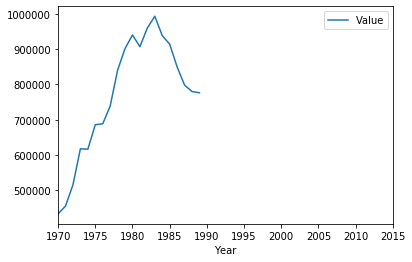

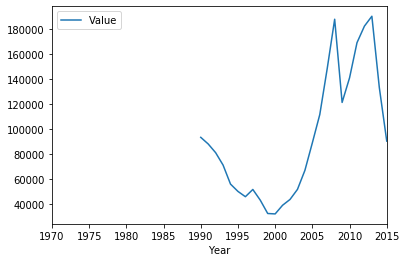

In [18]:
df_useful["GDP"][df_useful["GDP"]['Area']=='USSR'].plot(x ='Year', y='Value', kind = 'line')
df_useful["GDP"][df_useful["GDP"]['Area']=='Ukraine'].plot(x ='Year', y='Value', kind = 'line')

##### 1.D.b.ii. Proposed correction  <a name="1Dbii"></a> 

TODO (for countries which has appeared, give them value for previous year)
(for example in 1990 : Ukraine is X% of GPD of all countries that appeared from USSR so for 1970->1989 we give Ukraine value X%*GDP(USSR))

#### 1.D.c. Correcting inconsistent data entries  <a name="1Dc"></a>

In this section, we will create dataframes in `df_cleansed` which correspond to previous dataframes where the inconsistent data entries have been corrected.

In [19]:
df_cleansed = {}

### 1.E. Preprocessing the data set  <a name="1E"></a>

In this part, we will finish prepocessing the datasets. More precisely, we will deal with country names and normalizing the features.

#### 1.E.a. Converting country names between different naming conventions  <a name="1Ea"></a>

TODO, explain why (folium) + either Martin or Julien way to do it + show one map

In [20]:
def get_country_id(string_or,countries):
    
    countries.Name=countries.Name.apply(lambda x:x.lower())
    string=string_or.lower()
    
    if string in countries.Name:
        temp=countries.loc[countries.Name==string,'ID'].tolist
        return temp
    
    strs=string.split('-')
    if len(strs)>1:
        string= ' '.join(strs)

    if string=="côte d'ivoire":
        return ['CIV']
    if string=="united states of america":
        return ['USA']
    if string=="vietnam" or string=="viet nam":
        return ["VNM"]
    if string=="south africa":
        return ['ZAF']
    if string=='north korea' or string=="democratic people's republic of korea":
        return["PRK"]
    if string=="russian federation":
        return ["RUS"]
    if string=="cyprus":
        return ["CYP"]
    if string=="ussr":
        return ['RUS']
    delimiters = " and "," ",","
    pattern = '|'.join(map(re.escape, delimiters))
    strings=list(filter(None,re.split(pattern,string)))
    for s in strings:
        if s=="french":
            return ["FRA"]
        if s=="lao":
            return ["LAO"]
        if s in ['southern','islands','south','democratic','the','arab','united','central','states','republic','of','new','africa','america']:
            continue
        for name in countries.Name:
            if s in name.split():
                temp=countries.loc[countries.Name==name,'ID'].tolist()
                return temp
    return [np.nan]

def split_names(x):
    x=x.lower()
    if x!="guinea-bissau" and len(x.split('-'))>1:
        return x.split("-")
    if len(x.split(' & '))>1:
        return x.split(' & ')
    return x

def get_df_with_ids(df):
    
    df=df.copy()
    world_countries_file="Data/world-countries.json"
    geo_json_data=json.load(open(world_countries_file))
    names=[c['properties']['name'] for c in geo_json_data['features']]
    ids=[c['id'] for c in geo_json_data['features']]
    country_df=pd.DataFrame()
    country_df['Name']=names
    country_df['ID']=ids
    
    print("Exploding dataframe :")
    df.Area=df.Area.apply(lambda x: split_names(x))
    df=df.explode('Area')
    df.Area=df.Area.apply(lambda x:x.lower())
    
    print("Getting IDs :")
    
    countries_df=pd.DataFrame(df.Area.unique()).rename(columns={0:'Area'})
    
    countries_df['ID']=countries_df.Area.apply(lambda x: get_country_id(x,country_df)[0])
    countries_df.ID=countries_df.ID.replace("-99",np.nan)
    print(len(countries_df[countries_df.ID.isna()])," Countries without IDs")
    df=df.merge(countries_df,how='left')
    
    return df

#### 1.E.b. Normalization and log scales  <a name="1Eb"></a>

TODO, explain why (heavy tail, right skewed, power laws) + do it

For instance the distribution of GDP look a bit like a power law.

C:\Users\Martin\.conda\envs\ada\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Martin\.conda\envs\ada\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


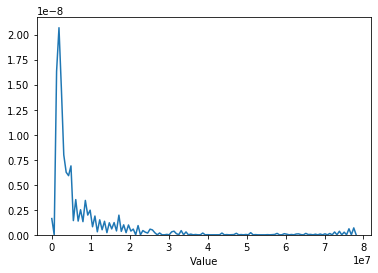

In [21]:
# NEED TO USE df_cleansed INSTEAD OF df_useful
sns.distplot(df_useful["GDP"]["Value"], rug=False, hist=False)

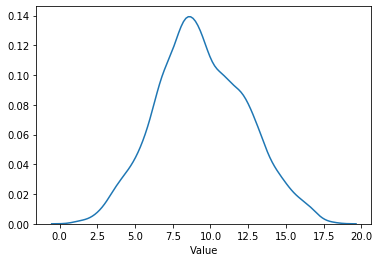

In [22]:
#looks better with log scale
sns.distplot(np.log(df_useful["GDP"]["Value"]), rug=False, hist=False)

### 1.F. Making one uniformized dataframe  <a name="1F"></a>

In this part, we will make one uniformized dataframe `uni_df` with the following columns.

(TO BE CHANGED, WAY MORE COLUMNS)

    Country | Year | GDP | Apples production | Livestock production | Crops importation | Livestock importation | Crops exportation | Livestock exportation
    
In this uniformized dataframe, a tuple `(Country, Year)` uniquely identifies a row.


#### 1.F.a. Pivoting dataframes with items  <a name="1Fa"></a>

In [23]:
# NEED TO USE df_cleansed INSTEAD OF df_useful
food_crop_area_df_pivoted = pd.pivot_table(df_useful['Crops Area harvested'], index=["Area Code","Area",'Year'], columns="Item", values="Value")
display(food_crop_area_df_pivoted.sample(10))

,,Item,"Anise, badian, fennel, coriander",Apples,Apricots,Areca nuts,Artichokes,Asparagus,Avocados,Bambara beans,Bananas,Barley,...,Sweet potatoes,"Tangerines, mandarins, clementines, satsumas",Taro (cocoyam),Tomatoes,Tung nuts,"Vegetables&Melons, Total",Vetches,Watermelons,Wheat,Yams
Area Code,Area,Year,,,,,,,,,,,,,,,,,,,,,
116,Democratic People's Republic of Korea,1992,NaN,72736.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55000.0,...,20000.0,NaN,NaN,8111.0,NaN,311820.0,NaN,5200.0,87588.0,NaN
69,French Guiana,1978,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,60.0,NaN,...,NaN,20.0,575.0,NaN,NaN,787.0,NaN,NaN,NaN,NaN
86,Grenada,1965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000.0,NaN,...,90.0,NaN,NaN,11.0,NaN,232.0,NaN,NaN,NaN,190.0
211,Switzerland,2013,NaN,3993.0,702.0,NaN,4.0,332.0,NaN,NaN,NaN,28574.0,...,NaN,NaN,NaN,212.0,NaN,15195.0,NaN,NaN,89101.0,NaN
5400,Europe,1975,10758.0,2074684.0,135355.0,NaN,93218.0,46157.0,335.0,NaN,15600.0,51827147.0,...,13011.0,83372.0,NaN,816508.0,NaN,5779545.0,1245800.0,655744.0,87393140.0,322.0
5102,Middle Africa,1987,NaN,NaN,88.0,NaN,NaN,NaN,16540.0,19900.0,185033.0,580.0,...,132170.0,0.0,158800.0,22250.0,NaN,215148.0,NaN,0.0,11371.0,131654.0
67,Finland,1996,NaN,437.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,542500.0,...,NaN,NaN,NaN,119.0,NaN,10118.0,NaN,NaN,112500.0,NaN
132,Maldives,1984,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,150.0,NaN,...,135.0,NaN,114.0,NaN,NaN,1241.0,NaN,NaN,NaN,NaN
45,Comoros,1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000.0,NaN,...,1400.0,NaN,NaN,NaN,NaN,615.0,NaN,NaN,NaN,NaN


In [24]:
# Deal with the NaN that appeared

#### 1.F.b. Merging everything  <a name="1Fb"></a>

In [25]:
def rename_columns(x, word):
    if x not in ['Area Code', 'Area', 'Year']:
        return x + ' ' + word
    return x
    
# NEED TO USE df_cleansed INSTEAD OF df_useful
gdp_df = df_useful['GDP'].rename(columns = {'Value':'GDP'})
food_area_df = food_crop_area_df_pivoted.rename(columns=lambda x: rename_columns(x, 'harvested area'))

pd.merge(gdp_df, food_area_df, how='outer', on=['Area', 'Area Code', 'Year'])

,Area Code,Area,Year,GDP,"Anise, badian, fennel, coriander harvested area",Apples harvested area,Apricots harvested area,Areca nuts harvested area,Artichokes harvested area,Asparagus harvested area,...,Sweet potatoes harvested area,"Tangerines, mandarins, clementines, satsumas harvested area",Taro (cocoyam) harvested area,Tomatoes harvested area,Tung nuts harvested area,"Vegetables&Melons, Total harvested area",Vetches harvested area,Watermelons harvested area,Wheat harvested area,Yams harvested area
0,2,Afghanistan,1970,1748.886597,NaN,3060.0,6630.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,76400.0,NaN,10900.0,2176000.0,NaN
1,2,Afghanistan,1971,1831.108982,NaN,3060.0,6630.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,76000.0,NaN,10900.0,2350000.0,NaN
2,2,Afghanistan,1972,1595.555482,NaN,3150.0,6810.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,76800.0,NaN,10900.0,2897100.0,NaN
3,2,Afghanistan,1973,1733.333275,NaN,3210.0,6950.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,76000.0,NaN,10900.0,2300000.0,NaN
4,2,Afghanistan,1974,2155.555500,NaN,3270.0,7070.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,78100.0,NaN,11200.0,2277600.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14327,5817,Net Food Importing Developing Countries,1965,NaN,21200.0,26139.0,23348.0,91438.0,10110.0,11000.0,...,771431.0,101010.0,233063.0,199925.0,12600.0,2191128.0,77740.0,101986.0,13191623.0,477181.0
14328,5817,Net Food Importing Developing Countries,1966,NaN,21200.0,24308.0,23729.0,65138.0,8420.0,7595.0,...,739420.0,23009.0,235023.0,208102.0,12800.0,2283258.0,69830.0,100765.0,13120622.0,483455.0
14329,5817,Net Food Importing Developing Countries,1967,NaN,21200.0,25741.0,27466.0,59947.0,8903.0,7180.0,...,744181.0,23348.0,240799.0,212310.0,13500.0,2312442.0,63650.0,92314.0,13152298.0,489006.0
14330,5817,Net Food Importing Developing Countries,1968,NaN,30770.0,19992.0,23641.0,59856.0,8770.0,6955.0,...,782610.0,24188.0,242907.0,218741.0,14800.0,2377616.0,65640.0,98595.0,13831391.0,504349.0


### 2. Data exploration and first observations  <a name="2"></a>

2. 
        
    1. [Food productions, importations and exportations](#2A)
            
    2. [Prices of food](#2B)      
                
    3. [Structure of international trade](#2C)       
        
    4. [Economic classification of countries](#2D)  
        
In this part, we will explore the dataset with more details. We will first see in more detail the [food productions, importations and exportations](#2A), next examine the [Prices of food](#2B), then study the [structure of international trade](#2C) and finally look at the [economic classification of countries](#2D).

#### 2.A. Food productions, importations and exportations <a name="2A"></a>

2. 
        
    1. 
    
        1. [Crops and livestock production and trade](#2Aa)  
    
            1. [Crops](#2Aai)
            
                1. [Production](#2Aai1)
                
                2. [Importation](#2Aai2)
                
                3. [Exportation](#2Aai3)
    
            2. [Livestock](#2Aaii)  
            
                1. [Production](#2Aaii1)
                
                2. [Importation](#2Aaii2)
                
                3. [Exportation](#2Aaii3)
    
            2. [Globally](#2Aaiii)             
    
        2. [Introducing the concept of food self-sufficiency](#2Ab)
    
            1. [Basic idea](#2Abi)
    
            2. [Formula and computation](#2Abii)
            
TODO

#### 2.B. Prices of food  <a name="2B"></a>

2. 
        
    2. 
    
        1. [Prices](#2Ba) 
    
        2. [Stability of prices](#2Bb)      
        
TODO

#### 2.C. Structure of international trade  <a name="2C"></a>

2.  
                
    3. 
    
        1. [One word about historical context](#2Ca) 
    
        2. [Clusters, circularity and openness rates of international trade](#2Cb)   

TODO

#### 2.D. Economic classification of countries <a name="2D"></a>
TODO

### 3. Descriptive data analysis  <a name="3"></a>

3. 

    1. [Production and consumption of food from a time-space geography point of view](#3A)
        
        1. [Net food exporters or importers](#3Aa)
        
        2. [Evolution over the last few decades](#3Ab)

    1. [Food self-sufficiency](#3B)

    2. [Giving countries an economic score based on their agricultural features](#3C)
        
        1. [Correlation between food trade feature and GDP](#3Ca)
        
        2. [Our own score](#3Cb)
        
        2. [Machine learning model](#3Cc)  

    3. [Food prices stability and agricultural features](#3C)  
    
TODO

### 4. Informed plan for next actions  <a name="4"></a>

TODO